In [1]:
import os
import copy
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from IPython.display import Image
cwd =  os.getcwd().replace("notebooks/research/impermanent_loss","")
os.chdir(cwd)

from python.dev.cpt import SolveDeltas
from python.dev.math.model import BrownianModel
from python.dev.cpt import Liquidity
from python.dev.cpt import LiquidityPoolUSD
from python.dev.math.model import EventSelectionModel
from python.dev.math.model import TokenDeltaModel

* https://medium.com/@chiqing/uniswap-v2-explained-beginner-friendly-b5d2cb64fe0f

In [2]:
from python.dev.simulation import SimulateLiquidity

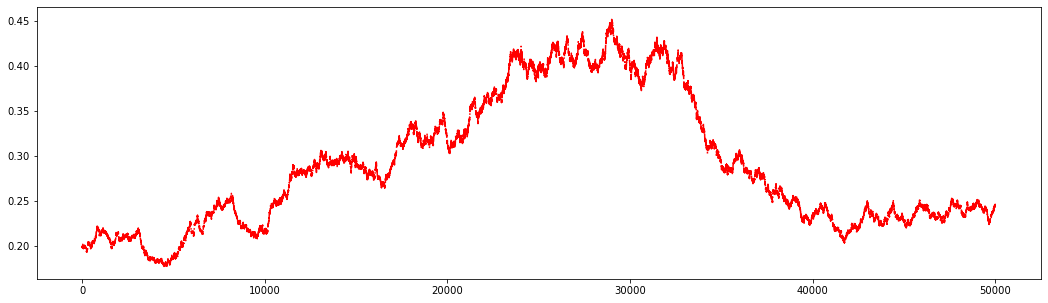

In [3]:
n_runs = 50000
start_price = 0.2
mu = 0.4
sigma = 0.5
n_paths = 1

b = BrownianModel(start_price)
p_arr = b.gen_gbm(mu, sigma, n_runs, n_paths)

x_val = np.arange(0,len(p_arr))
fig, (USD_ax) = plt.subplots(nrows=1, sharex=False, sharey=False, figsize=(18, 5))
USD_ax.plot(p_arr, color = 'r',linestyle = 'dashdot', label='initial invest') 

In [4]:
liq = Liquidity(10000, 2000, 'SYS','DIA')
simLiq = SimulateLiquidity(liq)
simLiq.run(p_arr)

sys_arr = simLiq.get_x_arr()
dai_arr = simLiq.get_y_arr()
dsys_arr  = simLiq.get_x_deltas_arr()
ddai_arr  = simLiq.get_y_deltas_arr()
fee_sys_arr = simLiq.get_fee_x_arr()
fee_dai_arr = simLiq.get_fee_y_arr()

simLiq.check(p_arr, 100)

raw: 0.1998294 y/x: 0.2017925 dy/dx: 0.2012394 liq: 4200.3935247


In [5]:
tdel = TokenDeltaModel(10000) 
liq2 = Liquidity(100000, 20000, 'SYS','DIA')
simLiq2 = SimulateLiquidity(liq2, tdel)
simLiq2.run(p_arr, lp_rate = 0.55)

sys_arr2 = simLiq2.get_x_arr()
dai_arr2 = simLiq2.get_y_arr()
dsys_arr2  = simLiq2.get_x_deltas_arr()
ddai_arr2  = simLiq2.get_y_deltas_arr()
fee_sys_arr2 = simLiq2.get_fee_x_arr()
fee_dai_arr2 = simLiq2.get_fee_y_arr()

simLiq2.check(p_arr, 1000)

raw: 0.2136889 y/x: 0.2184714 dy/dx: 0.2163438 liq: 127475.7459343


In [6]:
fee_dai_arr2[-1] + p_arr[-1]*fee_sys_arr2[-1]

27.575283547972536

In [7]:
usd_arr  = simLiq.get_usd_arr()
usd_arr2  = simLiq2.get_usd_arr()

**Initial USD investment**

In [8]:
N = 1000
dai_arr[0] + p_arr[0]*sys_arr[0]

4000.0

**1. HODL Value at N**

In [9]:
hodl_value = dai_arr[0] + p_arr[N]*sys_arr[0]
hodl_value

4136.889028209276

**SYS HODL value at N**

In [10]:
2*sys_arr2[0]*p_arr[N]

42737.78056418552

**2. LP MC USD value at N**

In [11]:
dai_arr2[N] + sys_arr2[N]*p_arr[N]

117862.36119248369

**4. Pool holdings value at N**

In [12]:
dai_sys_arr = np.sqrt(dai_arr*sys_arr)
dai_sys_usd_arr = dai_sys_arr/(dai_arr + sys_arr*p_arr)
dai_sys_arr[0]/dai_sys_usd_arr[N]

4134.629194332345

**Calculations**

In [13]:
lpVal = LiquidityPoolUSD(sys_arr2, dai_arr2, p_arr)

**1. HODL USD value at N**

In [14]:
hodl_usd = lpVal.hodl_position_usd(sys_arr[0], dai_arr[0])
hodl_usd[N]

4136.889028209276

**2. LP MC USD value at N**

In [15]:
lp_mc_usd = lpVal.lp_marketcap_usd()
lp_mc_usd[N]

117862.36119248369

**3. USD / LP at N**

In [16]:
lpVal.usd_per_lp(N)

0.9245865582403917

**4. Pool holdings value at N**

In [17]:
lp_pos = lpVal.lp_position_usd(sys_arr[0], dai_arr[0])
lp_pos[N]

4134.876790616168

In [18]:
hodl_pos = lpVal.hodl_position_usd(sys_arr[0], dai_arr[0])
hodl_pos[N]

4136.889028209276

In [19]:
lp_pos2 = lpVal.lp_position_usd(sys_arr2[0], dai_arr2[0])
fees = fee_dai_arr2 + p_arr[1:]*fee_sys_arr2
fees[-1]/(lp_pos2[-1]+fees[-1])

0.0006191441563617216

In [20]:
lpVal.lp_position_usd(sys_arr2[0], dai_arr2[0], 50000)

44510.16809113434

In [21]:
lpVal.lp_position_usd(1000, 200, 50000)

445.1016809113434

In [22]:
fee_dai_arr2[0] + p_arr[0]*fee_sys_arr2[0]

0.025008542670944864

In [39]:
fees = fee_dai_arr2 + p_arr[1:]*fee_sys_arr2

In [40]:
lp_pos2 = lpVal.lp_position_usd(sys_arr2[0], dai_arr2[0])
fees = fee_dai_arr2 + p_arr[1:]*fee_sys_arr2
fees[-1]/(lp_pos2[-1]+fees[-1])

0.0006191441563617216

In [35]:
init_pos_sys = 1000
init_pos_dai = p_arr[0]*init_pos_sys

lp_pos = lpVal.lp_position_usd(init_pos_sys, init_pos_dai)
lp_tot = lpVal.lp_tot_usd()

collected_fees = fees*lp_pos[1:]/lp_tot[1:]
lp_pos_collected_fees = np.cumsum(collected_fees)

lp_pos_collected_fees[-1]/lp_pos[0]

0.134148720255084

In [38]:
print('collected fees ${:.2f}'.format(lp_pos_collected_fees[-1]))

collected fees $53.66


In [26]:
fees[-1]

27.575283547972536

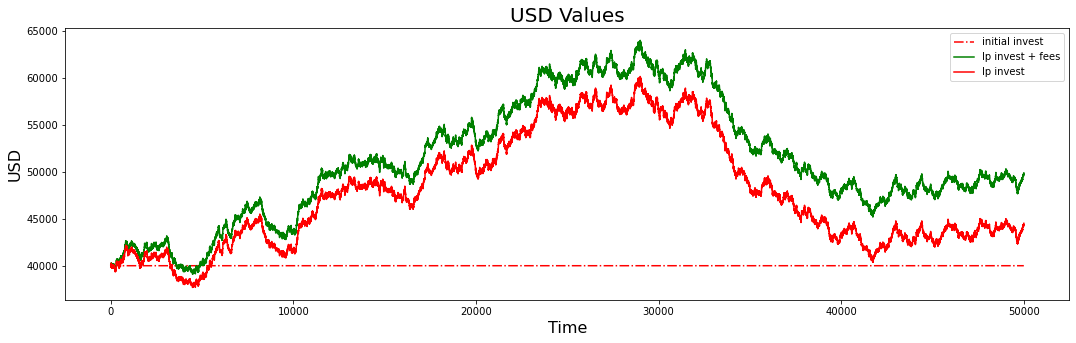

In [27]:
x_val = np.arange(0,len(p_arr))
fig, (USD_ax) = plt.subplots(nrows=1, sharex=False, sharey=False, figsize=(18, 5))
USD_ax.plot(x_val, np.repeat(40000, len(p_arr)), color = 'r',linestyle = 'dashdot', label='initial invest') 
#USD_ax.plot(x_val, lp_mc_usd, color = 'b',label='lp marketcap') 
USD_ax.plot(x_val[1:], lp_pos[1:] + lp_pos_collected_fees, color = 'g',label='lp invest + fees') 
USD_ax.plot(x_val[1:], lp_pos[1:], color = 'r',label='lp invest') 
#USD_ax.plot(x_val, hodl_pos, color = 'g',label='hodl') 
USD_ax.set_title("USD Values", fontsize=20)
USD_ax.set_ylabel("USD", fontsize=16)
USD_ax.set_xlabel('Time', fontsize=16)
USD_ax.legend()

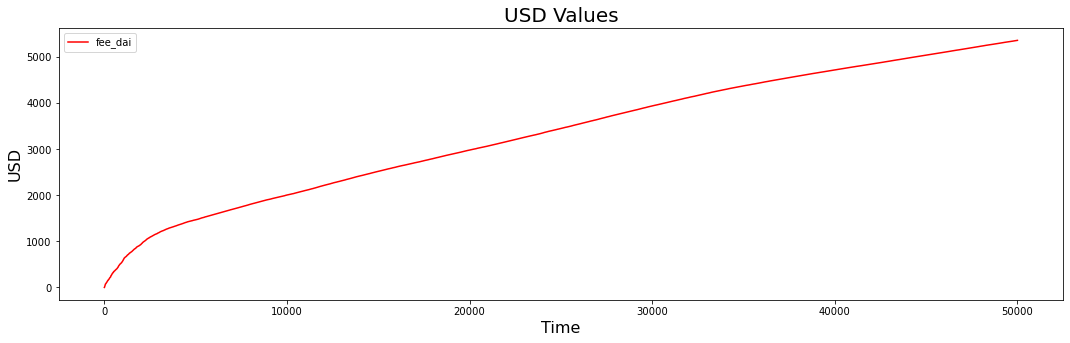

In [28]:
x_val = np.arange(0,len(p_arr))
fig, (fee_ax) = plt.subplots(nrows=1, sharex=False, sharey=False, figsize=(18, 5))
#fee_ax.plot(x_val[1:], fee_sys_arr, color = 'b',label='fee_sys') 
fee_ax.plot(x_val[1:], lp_pos_collected_fees, color = 'r',label='fee_dai') 
fee_ax.set_title("USD Values", fontsize=20)
fee_ax.set_ylabel("USD", fontsize=16)
fee_ax.set_xlabel('Time', fontsize=16)
fee_ax.legend()

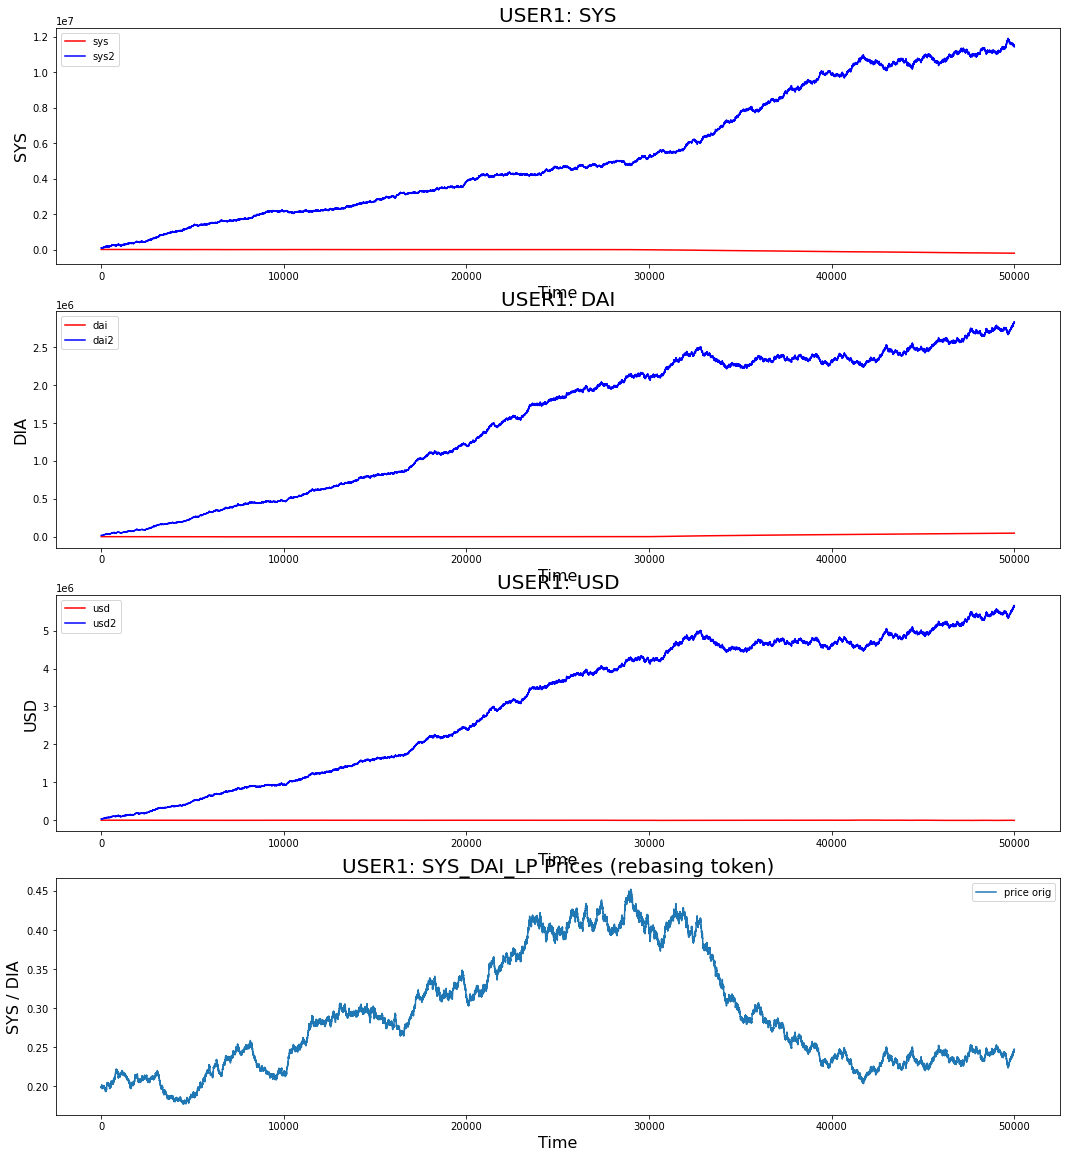

In [29]:
fig, (SYS_ax, DAI_ax, USD_ax, price_ax) = plt.subplots(nrows=4, sharex=False, sharey=False, figsize=(18, 20))
SYS_ax.plot(sys_arr, color = 'r',label='sys') 
SYS_ax.plot(sys_arr2, color = 'b',label='sys2') 
SYS_ax.set_title("USER1: SYS", fontsize=20)
SYS_ax.set_ylabel("SYS", fontsize=16)
SYS_ax.set_xlabel('Time', fontsize=16)
SYS_ax.legend()

DAI_ax.plot(dai_arr, color = 'r', label='dai') 
DAI_ax.plot(dai_arr2, color = 'b',label='dai2') 
DAI_ax.set_title("USER1: DAI", fontsize=20)
DAI_ax.set_ylabel("DIA", fontsize=16)
DAI_ax.set_xlabel('Time', fontsize=16)
DAI_ax.legend()

USD_ax.plot(usd_arr, color = 'r', label='usd') 
USD_ax.plot(usd_arr2, color = 'b',label='usd2') 
USD_ax.set_title("USER1: USD", fontsize=20)
USD_ax.set_ylabel("USD", fontsize=16)
USD_ax.set_xlabel('Time', fontsize=16)
USD_ax.legend()

price_ax.plot(p_arr, label='price orig') 
price_ax.set_title("USER1: SYS_DAI_LP Prices (rebasing token)", fontsize=20)
price_ax.set_ylabel("SYS / DIA", fontsize=16)
price_ax.set_xlabel('Time', fontsize=16)
price_ax.legend()